# Orderbooks and Asset Pricing

In [1]:
import pandas as pd
import numpy as np 
import pickle
import scipy.stats as sts
from sklearn.linear_model import LinearRegression
import scipy.stats as sts
from matplotlib import pyplot as plt

### Datasets

In [2]:
SPY = pickle.load(open('data/SPY', 'rb'))
THO = pickle.load(open('data/THO', 'rb'))
GBX = pickle.load(open('data/GBX', 'rb'))
AAPL = pickle.load(open('data/AAPL', 'rb'))
C = pickle.load(open('data/C', 'rb'))

### Problem 1

In [4]:
class Orderbook(object):
    
    def __init__(self, file, instance, name):
        self.name = name
        self.timestamp = file[instance][0]
        self.data = file[instance][1]
        
        # Construction of orderbook
        OB = pd.DataFrame.from_dict(self.data, orient='index')
        OB.drop(columns=[2,3], inplace=True)
        OB.reset_index(inplace=True)
        OB.columns = ['price', 'quantity', 'side']
        
        self.buy = OB[OB.side == 'B'].sort_values('price', ascending=False) 
        self.buy['y'] = - self.buy.quantity.cumsum()

        self.sell = OB[OB.side == 'S'].sort_values('price', ascending=True) 
        self.sell['y'] = self.sell.quantity.cumsum()
        
        OB = pd.concat([self.buy, self.sell]).sort_values('price', ascending=True)
        OB.fillna(0, inplace=True)
        self.OB = OB
        
        self.BBO = self.__get_BBO()
        
        
    def __get_BBO(self):
        best_offer = self.OB[self.OB.side == 'S'].price.min()
        best_bid = self.OB[self.OB.side == 'B'].price.max()
        BBO = (best_offer + best_bid) / 2 
        return BBO
    
    
    def __estimate(self, OB):
        slope, intercept, r_value, p_value, std_err = \
                    sts.linregress(OB.price, OB.y)
        
        gamma = intercept
        beta = slope
        p0_estimate = - gamma / beta
        return gamma, beta, p0_estimate
    
    
    def plot(self):
        fig = plt.figure(figsize=(8,6))     
        plt.plot(self.OB.price, self.OB.y, label="Orderbook")
        plt.xlabel("Price")
        plt.ylabel("Quantity")
        plt.xlim(self.BBO * 0.8, self.BBO * 1.2)
        plt.ylim(self.OB.y.min() * 1.1, self.OB.y.max() * 1.1)
        plt.title("Stock {} at time = {}".format(self.name, self.timestamp))
        plt.legend(loc='lower right')
        
        
    def plot_estimate(self, fraction):
        OB_frac = self.OB[(self.OB.price <= self.BBO * (1 + fraction)) 
                          & (self.OB.price >= self.BBO * (1 - fraction))]
        
        gamma, beta, p0_estimate = self.__estimate(OB_frac)
        percent = fraction * 100
        estimate = gamma + beta * self.OB.price
        plt.plot(self.OB.price, estimate, label='Approximation within {}% of BBO'.format(percent))
        plt.legend(loc='lower right')
        
        
    def get_estimate_stats(self, fraction):
        OB_frac = self.OB[(self.OB.price <= self.BBO * (1 + fraction)) 
                          & (self.OB.price >= self.BBO * (1 - fraction))]
        
        gamma, beta, p0_estimate = self.__estimate(OB_frac)
        return beta, p0_estimate    

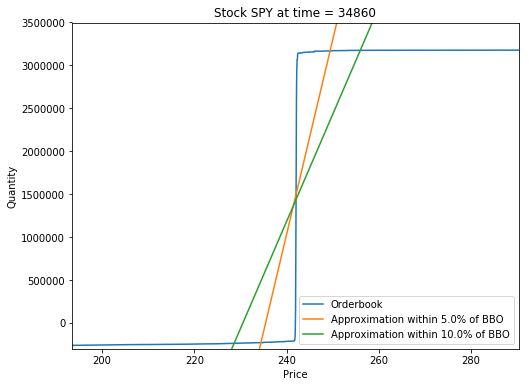

In [5]:
orderbook = Orderbook(SPY, 10, "SPY")
orderbook.plot()
orderbook.plot_estimate(0.05)
orderbook.plot_estimate(0.1)

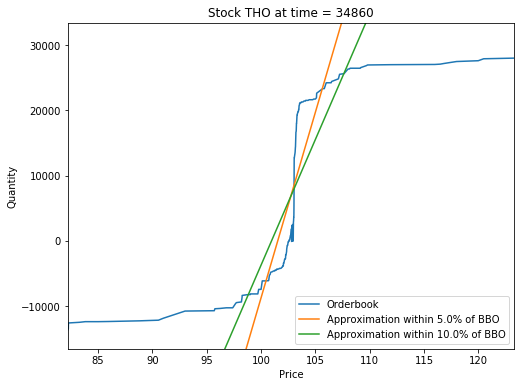

In [6]:
orderbook = Orderbook(THO, 10, "THO")
orderbook.plot()
orderbook.plot_estimate(0.05)
orderbook.plot_estimate(0.1)

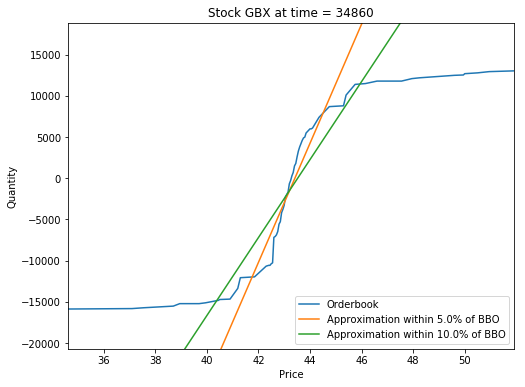

In [7]:
orderbook = Orderbook(GBX, 10, "GBX")
orderbook.plot()
orderbook.plot_estimate(0.05)
orderbook.plot_estimate(0.1)

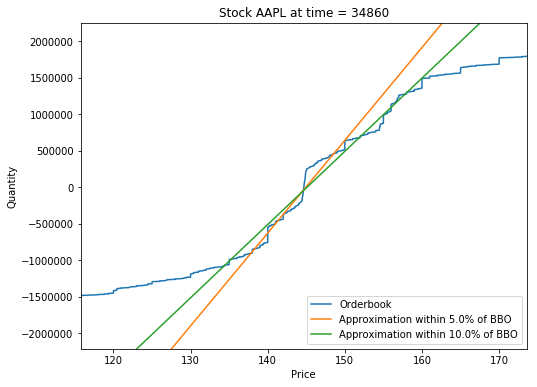

In [8]:
orderbook = Orderbook(AAPL, 10, "AAPL")
orderbook.plot()
orderbook.plot_estimate(0.05)
orderbook.plot_estimate(0.1)

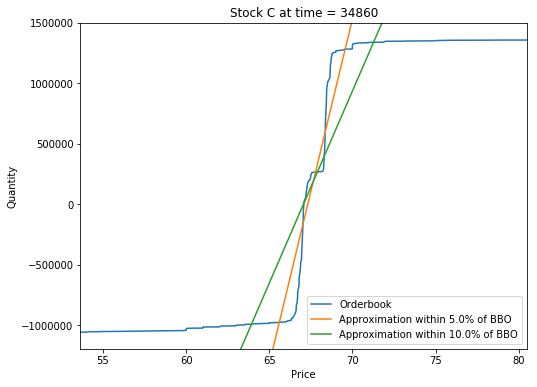

In [9]:
orderbook = Orderbook(C, 10, "C")
orderbook.plot()
orderbook.plot_estimate(0.05)
orderbook.plot_estimate(0.1)

As can be seen from the graphs above, the model fits well around the BBO. Therefore, I have used only a subset of the orderbook to estimate the model. I estimated based on orderbook transactions that are within 5% and 10% of BBO.

### Problem 2

In [10]:
class Ticker(object):
    
    def __init__(self, file, name):
        self.tickers = file
        self.name = name
        
        
    def __get_ratios(self, frac_list):
        
        timestamps = []
        ratios_mat = np.zeros((len(frac_list), len(self.tickers)))
        for i in range(len(self.tickers)):
            OB = Orderbook(self.tickers, i, self.name)
            timestamps.append(OB.timestamp)
            
            for j in range(len(frac_list)):
                beta, p0_estimate = OB.get_estimate_stats(frac_list[j])
                ratios_mat[j, i] = beta
        
        return timestamps, ratios_mat
    
    
    def plot_ratio(self, frac_list):
        
        timestamps, ratios_mat = self.__get_ratios(frac_list)
        
        fig = plt.figure(figsize=(8,6))
        
        for i in range(len(frac_list)):
            percent = frac_list[i] * 100
            plt.plot(timestamps, ratios_mat[i,:], label="$p_0$ estimate within {} of BBO".format(percent))
            
        plt.title(r"Market Maker Belief about Ratio $\frac{2\sigma_u}{\sqrt{\Sigma_0}}$ for Stock " + self.name)
        plt.xlabel("Time")
        plt.ylabel(r'Ratio $\frac{2\sigma_u}{\sqrt{\Sigma_0}}$')
        plt.legend(loc='lower right')
        plt.show()
        
    
    def __get_p0s(self, frac_list):
        
        timestamps = []
        BBO_list = []
        p0_estimate_mat = np.zeros((len(frac_list), len(self.tickers)))
        for i in range(len(self.tickers)):
            OB = Orderbook(self.tickers, i, self.name)
            timestamps.append(OB.timestamp)
            BBO_list.append(OB.BBO)
            
            for j in range(len(frac_list)):
                beta, p0_estimate = OB.get_estimate_stats(frac_list[j])
                p0_estimate_mat[j, i] = p0_estimate
                
        return timestamps, BBO_list, p0_estimate_mat
    
        
    def plot_p0s(self, frac_list):
        
        timestamps, BBO_list, p0_estimate_mat = self.__get_p0s(frac_list)
                
        fig = plt.figure(figsize=(8,6))
        plt.plot(timestamps, BBO_list, label="BBO")
        plt.title(r"Estimate of $P_0$ for Stock " + self.name)
        plt.xlabel("Time")
        plt.ylabel(r'$P_0$')
        
        for i in range(len(frac_list)):
            percent = frac_list[i] * 100
            plt.plot(timestamps, p0_estimate_mat[i,:], label="$p_0$ estimate within {} of BBO".format(percent))
        
        plt.legend(loc='lower right')  
        plt.show()

In [11]:
SPY_ticker = Ticker(SPY, "SPY")
THO_ticker = Ticker(THO, "THO")
GBX_ticker = Ticker(GBX, "GBX")
AAPL_ticker = Ticker(AAPL, "AAPL")
C_ticker = Ticker(C, "C")
frac_list = [0.05, 0.1]

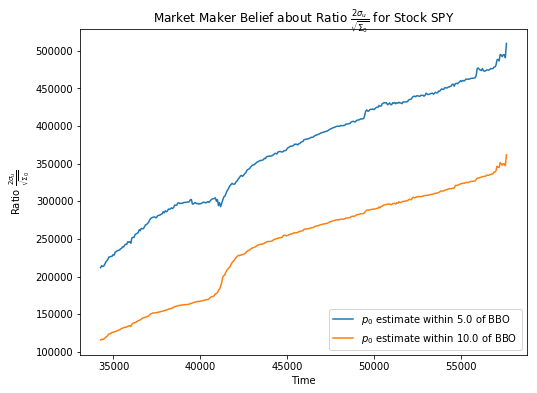

In [12]:
SPY_ticker.plot_ratio(frac_list)

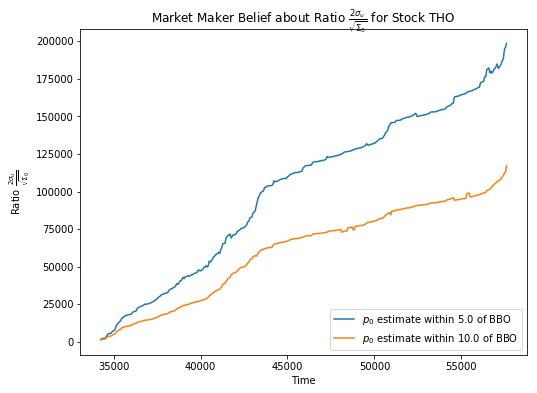

In [13]:
THO_ticker.plot_ratio(frac_list)

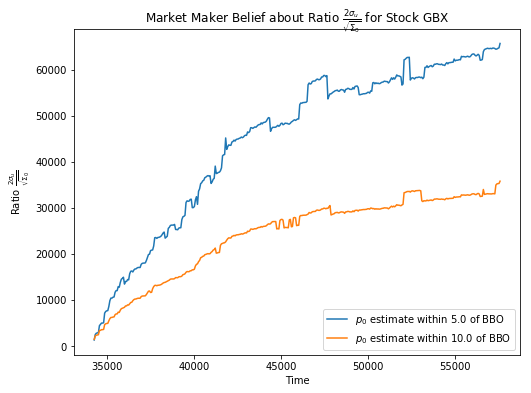

In [14]:
GBX_ticker.plot_ratio(frac_list)

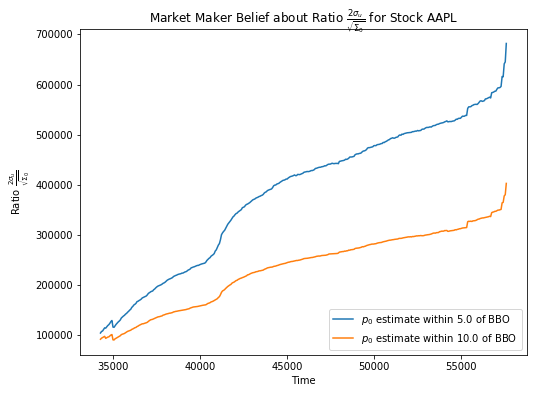

In [15]:
AAPL_ticker.plot_ratio(frac_list)

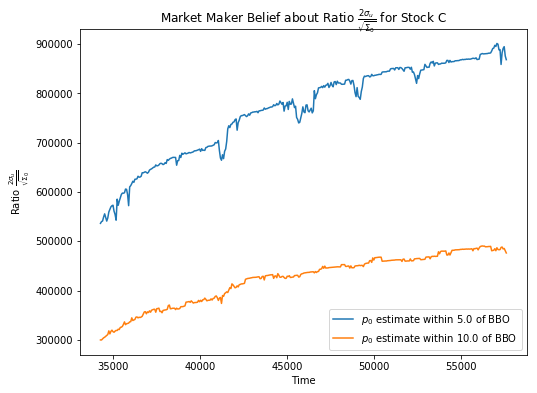

In [16]:
C_ticker.plot_ratio(frac_list)

### Problem 3

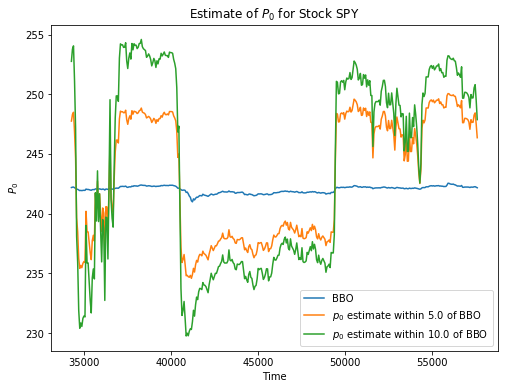

In [17]:
SPY_ticker.plot_p0s(frac_list)

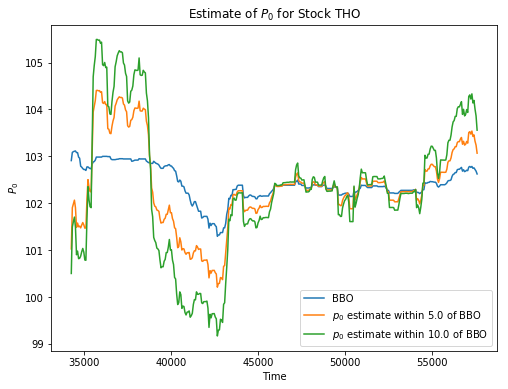

In [18]:
THO_ticker.plot_p0s(frac_list)

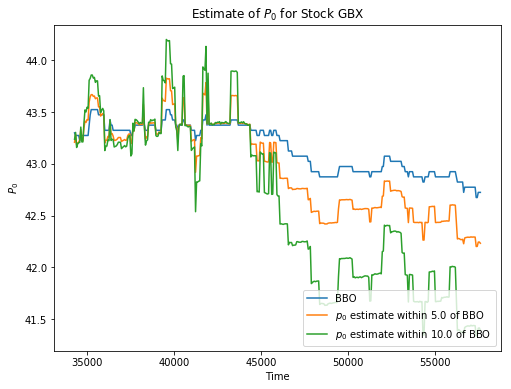

In [19]:
GBX_ticker.plot_p0s(frac_list)

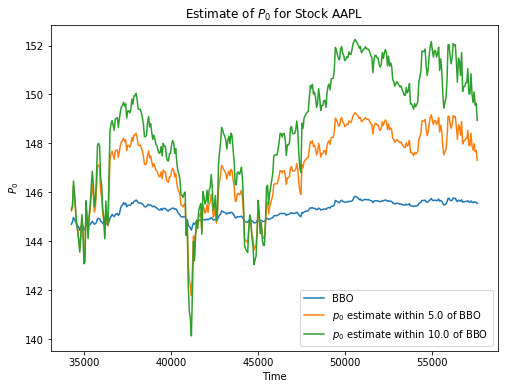

In [20]:
AAPL_ticker.plot_p0s(frac_list)

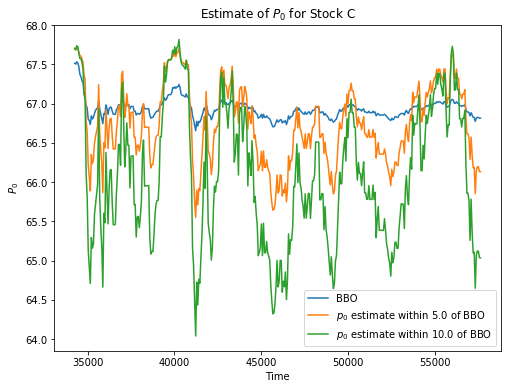

In [21]:
C_ticker.plot_p0s(frac_list)

The $p_0$ estimates seem to fluctuate much more throughout a particular day than the actual BBO. Moreover, it seems that the $p_0$ estimates are significantly different from the BBO for each timestamp. Since the $p_0$ are estimated within a certain percentage around the BBO for each time stamp, this difference could imply that our esimation procedure is not accurate to approximate the Orderbook even around the BBO.

### Problem 4

On average, for all stocks the noise/signal ratios are increasing throughout the day for both 5% and 10% estimates within BBO. This is consistent with what we would expect as the property of the Kyle Orderbook. On average, large swings in demand is caused by informed traders because market makers are concerned about the risk of losing to informed traders, so they offer relatively small amounts of share near the BBO. Thus, thick orderbooks arise when there is lot of noise from market makers and little variance in informed trader demand. When considering the noise/signal rations throughout a day, initially, informed traders are worried that there could be big news within that day, which could cause variance for the value of asset (change in $p_0$). However, as time passes, there is less fear of big news. This leads to less vairnce in informed trader demand causing the orderbook to become thicker. As a result, we see an increasing noise/signal ratio throughout the day. The fact that the orderbook becomes thicker later in the day can be seen from the following two orderbooks at different timestamps:

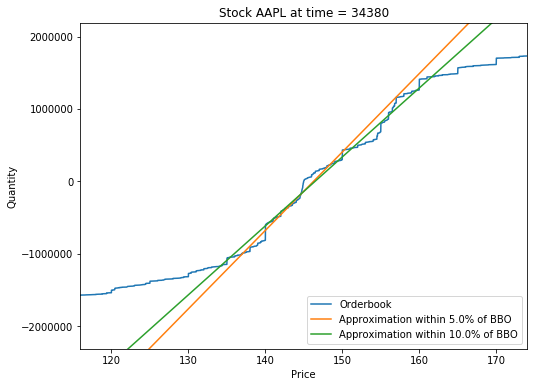

In [25]:
orderbook = Orderbook(AAPL, 2, "AAPL")
orderbook.plot()
orderbook.plot_estimate(0.05)
orderbook.plot_estimate(0.1)

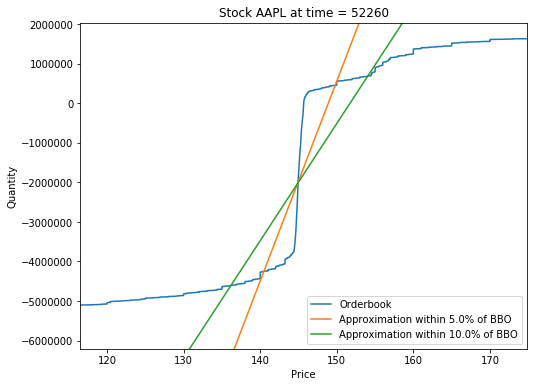

In [26]:
orderbook = Orderbook(AAPL, 300, "AAPL")
orderbook.plot()
orderbook.plot_estimate(0.05)
orderbook.plot_estimate(0.1)

Given the property of the Kyle Orderbook explained above, we would expect more variance in the movement of $p_0$ in the morning like Stock THO. However, this explanation does not seem to be consistent across all stocks. The difference in estimation of $p_0$ from the BBO can be explained from our procedure of approximation. Since, we are using 5% and 10% variation around BBO and doing a linear fit, the $p_0$ will only align with the BBO if the orderbook is symmetric around the BBO. However, this does not necessarily seem to be the case.

In terms, of the accuracy of estimating $p_0$, we can expect that it would be harder to estimate orderbooks later at night as the orderbook tend to be thick. In other words, we would expect that we need to approximate closer to the BBO in order to get a good linear approximation of the Orderbook.